# Lecture 10A — Notebook 10A.2: Liftering Design, Envelope vs Excitation (Multi-frame)

**Purpose:** Go beyond one frame: apply liftering across many frames in a selection, quantify smoothness, and compare voiced vs unvoiced segments.

This notebook follows the **EE519 hands-on protocol** (Lectures 7–9): manifest workflow, micro-checkpoints, debugging hints, saved figures, and reflection wrap-up.


In [1]:
import os, json, math, re
from pathlib import Path

import numpy as np
import scipy.signal as sig
import scipy.fft as fft
import matplotlib.pyplot as plt

# Optional: recording in notebook
try:
    import sounddevice as sd
    HAS_SD = True
except Exception as e:
    HAS_SD = False
    print("sounddevice not available (recording disabled).", e)

# Optional: playback in notebook
try:
    from IPython.display import Audio, display
    HAS_IPY_AUDIO = True
except Exception:
    HAS_IPY_AUDIO = False

# ---------- Project paths ----------
PROJECT_ROOT = Path.cwd() / "EE519_L10A_Project"
REC_DIR = PROJECT_ROOT / "recordings"
FIG_DIR = PROJECT_ROOT / "figures"
MANIFEST_PATH = PROJECT_ROOT / "manifest.json"

for d in [REC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def load_manifest(path=MANIFEST_PATH):
    if path.exists():
        return json.loads(path.read_text())
    return {"course":"EE519","lecture":"10A","created_utc":None,"clips":[]}

def save_manifest(manifest, path=MANIFEST_PATH):
    if manifest.get("created_utc") is None:
        manifest["created_utc"] = str(np.datetime64("now"))
    path.write_text(json.dumps(manifest, indent=2))
    print("Saved manifest:", path)

manifest = load_manifest()

def save_fig(fig, name, dpi=150):
    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved figure:", out)
    return out

# ---------- WAV I/O ----------
import wave
def write_wav(path: Path, x: np.ndarray, fs: int):
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1.0, 1.0)
    x_i16 = (x * 32767.0).astype(np.int16)
    with wave.open(str(path), "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(fs)
        wf.writeframes(x_i16.tobytes())

def read_wav(path: Path):
    with wave.open(str(path), "rb") as wf:
        fs = wf.getframerate()
        n = wf.getnframes()
        x = np.frombuffer(wf.readframes(n), dtype=np.int16).astype(np.float32) / 32768.0
    return fs, x

def peak_normalize(x, target=0.98):
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * target

def play_audio(x, fs, label="audio"):
    if not HAS_IPY_AUDIO:
        print("(Audio playback not available)", label)
        return
    display(Audio(x, rate=fs))

def record_clip(seconds=2.0, fs=16000):
    if not HAS_SD:
        raise RuntimeError("sounddevice not available. Load wav files instead.")
    print(f"Recording {seconds:.1f}s @ {fs} Hz ...")
    x = sd.rec(int(seconds*fs), samplerate=fs, channels=1, dtype="float32")
    sd.wait()
    return fs, x.squeeze()

def add_clip_to_manifest(filename, label, fs, notes=""):
    clip = {
        "filename": filename,
        "label": label,
        "fs": int(fs),
        "notes": notes,
        "added_utc": str(np.datetime64("now")),
        "selections": {}
    }
    manifest["clips"].append(clip)
    save_manifest(manifest)
    return len(manifest["clips"]) - 1

def list_clips():
    for i,c in enumerate(manifest["clips"]):
        print(f"[{i}] {c['label']:12s}  {c['filename']}  fs={c['fs']}  notes={c.get('notes','')}")

# ---------- Framing helpers ----------
def frame_signal(x, N, H):
    if len(x) < N:
        x = np.pad(x, (0, N-len(x)))
    num = 1 + (len(x) - N)//H
    idx = np.arange(N)[None,:] + H*np.arange(num)[:,None]
    return x[idx]

def seconds_to_samples(t0, t1, fs, xlen):
    s0 = int(max(0, round(t0*fs)))
    s1 = int(min(xlen, round(t1*fs)))
    if s1 <= s0:
        raise ValueError("Bad selection: t1 must be > t0")
    return s0, s1

def samples_to_frame_range(s0, s1, N, H, xlen):
    f0 = max(0, int((s0 - N)//H) + 1)
    f1 = min(int((s1)//H), int((xlen-N)//H))
    if f1 < f0:
        f0 = max(0, int(s0//H))
        f1 = min(int((xlen-N)//H), f0)
    return f0, f1

def db(x):
    return 20*np.log10(np.maximum(x, 1e-12))

print("Project root:", PROJECT_ROOT)
print("Clips in manifest:", len(manifest["clips"]))


Project root: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project
Clips in manifest: 19


## 1) Choose clip + selection (use your manifest selections)

If you haven't created selections yet, go back to **Notebook 10A.0**.


In [2]:
list_clips()
CLIP_IDX = 0
clip = manifest["clips"][CLIP_IDX]
fs, x = read_wav(REC_DIR/clip["filename"])
x = peak_normalize(x)

print("Selected:", CLIP_IDX, clip["label"], clip["filename"], "fs=", fs)
print("Available segments:", list(clip.get("selections", {}).get("analysis_segments", {}).keys()))


[0] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[1] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[2] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[3] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[4] sentence      student_sentence.wav  fs=16000  notes=short sentence
[5] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[6] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[7] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[8] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[9] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[10] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[11] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[12] sentence      student_sentence.wav  fs=16000  notes=short sentence
[13] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[14] vowel_a       student_vowel_a.wav  fs=16000  note

In [3]:
segment_name = "vowel_mid"  # choose an existing segment name
sel = clip["selections"]["analysis_segments"][segment_name]

WIN_MS = sel["win_ms"]; HOP_MS = sel["hop_ms"]
N = sel["N"]; H = sel["H"]
f0, f1 = sel["frame_range"]
window = sig.windows.hann(N, sym=False)

print("Segment:", segment_name, "frames:", (f0, f1), "N/H:", (N, H))


Segment: vowel_mid frames: (98, 150) N/H: (400, 160)


### Micro-checkpoint
- [ ] Your selection is steady (vowel mid or fricative mid)
- [ ] Frame range includes at least ~10 frames (for multi-frame stats)


## 2) Multi-frame cepstrum computation

For each frame in the selection:
- compute log-magnitude spectrum
- compute real cepstrum
- apply liftering (envelope + excitation)
- reconstruct envelope magnitude

We'll keep everything in arrays for later visualization.


In [4]:
frames = frame_signal(x, N, H)
NFFT = 2048 if fs <= 16000 else 4096

frame_ids = np.arange(f0, f1+1)
K = len(frame_ids)

# storage
logmag_all = []
cep_all = []
env_db_all = []
exc_db_all = []

Q_CUT_MS = 2.5  # start point; you will sweep later

def lifter_lowpass(cep, fs, q_cut_ms):
    q = np.arange(len(cep))/fs * 1000.0
    mask = (q <= q_cut_ms).astype(float)
    return cep * mask

def lifter_highpass(cep, fs, q_cut_ms):
    q = np.arange(len(cep))/fs * 1000.0
    mask = (q >= q_cut_ms).astype(float)
    return cep * mask

for fi in frame_ids:
    fr = frames[fi] * window
    X = fft.rfft(fr, n=NFFT)
    mag = np.abs(X) + 1e-12
    logmag = np.log(mag)
    cep = fft.irfft(logmag, n=NFFT)

    # lifter
    cep_env = lifter_lowpass(cep, fs, Q_CUT_MS)
    cep_exc = lifter_highpass(cep, fs, Q_CUT_MS)

    # reconstruct magnitude
    logmag_env = np.real(fft.rfft(cep_env, n=NFFT))
    logmag_exc = np.real(fft.rfft(cep_exc, n=NFFT))
    mag_env = np.exp(logmag_env)
    mag_exc = np.exp(logmag_exc)

    env_db_n = db(mag_env) - np.max(db(mag_env))
    exc_db_n = db(mag_exc) - np.max(db(mag_exc))

    logmag_all.append(logmag)
    cep_all.append(cep)
    env_db_all.append(env_db_n)
    exc_db_all.append(exc_db_n)

logmag_all = np.stack(logmag_all, axis=0)  # (K, F)
cep_all = np.stack(cep_all, axis=0)        # (K, NFFT)
env_db_all = np.stack(env_db_all, axis=0)  # (K, F)
exc_db_all = np.stack(exc_db_all, axis=0)

freqs = np.linspace(0, fs/2, env_db_all.shape[1])
quef_ms = (np.arange(NFFT)/fs)*1000.0

print("Computed multi-frame cepstrum:", cep_all.shape, "env_db:", env_db_all.shape)


Computed multi-frame cepstrum: (53, 2048) env_db: (53, 1025)


## 3) Visualize cepstrum across frames (a cepstrogram-like view)

We show a heatmap of cepstrum magnitude for low quefrency (0–20 ms).
Interpretation:
- steady voiced: clear ridge/peak around pitch period
- fricatives: weaker structure


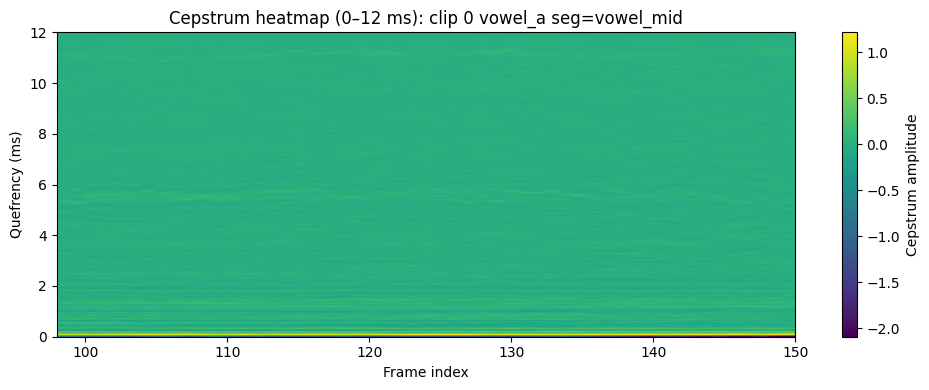

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\cepstrogram_clip0_vowel_mid.png


WindowsPath('c:/Users/K/Documents/usc/ee519/ee519-lecture/lecture9/EE519_L10A_Project/figures/cepstrogram_clip0_vowel_mid.png')

In [5]:
QMAX_MS = 12.0
qmask = quef_ms <= QMAX_MS
C = cep_all[:, qmask]
#C = C[10:, :]

fig = plt.figure(figsize=(10,4))
plt.imshow(C.T, aspect="auto", origin="lower",
           extent=[frame_ids[0], frame_ids[-1], quef_ms[qmask][0], quef_ms[qmask][-1]])
plt.title(f"Cepstrum heatmap (0–{QMAX_MS:.0f} ms): clip {CLIP_IDX} {clip['label']} seg={segment_name}")
plt.xlabel("Frame index")
plt.ylabel("Quefrency (ms)")
plt.colorbar(label="Cepstrum amplitude")
plt.tight_layout(); plt.show()

save_fig(fig, f"cepstrogram_clip{CLIP_IDX}_{re.sub(r'[^a-zA-Z0-9_]+','_',segment_name)}.png")


In [6]:
np.shape(C)


(53, 193)

## 4) Envelope smoothness metric (simple but useful)

We want an envelope that is smooth (not tracking harmonics). One quick metric:
- compute the first difference across frequency and average absolute value.
Lower → smoother.

We'll sweep q-cut and choose a value that balances smoothness and detail.


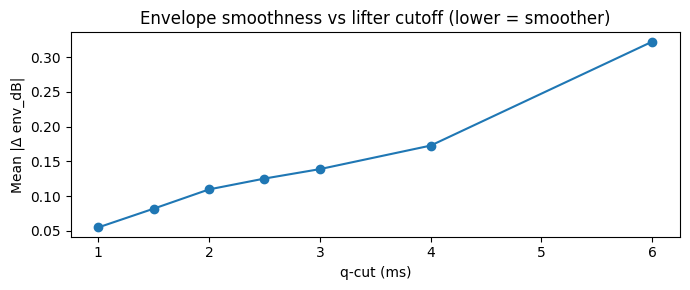

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\lifter_qcut_smoothness_clip0_vowel_mid.png


WindowsPath('c:/Users/K/Documents/usc/ee519/ee519-lecture/lecture9/EE519_L10A_Project/figures/lifter_qcut_smoothness_clip0_vowel_mid.png')

In [7]:
def envelope_smoothness(env_db_n):
    # env_db_n: (F,) normalized envelope dB
    return np.mean(np.abs(np.diff(env_db_n)))

def compute_sweep_metrics(qcuts):
    metrics = []
    for q in qcuts:
        env_db_all_tmp = []
        for i,fi in enumerate(frame_ids):
            cep = cep_all[i]
            cep_env = lifter_lowpass(cep, fs, q)
            mag_env = np.exp(np.real(fft.rfft(cep_env, n=NFFT)))
            env_db_n = db(mag_env) - np.max(db(mag_env))
            env_db_all_tmp.append(envelope_smoothness(env_db_n))
        metrics.append(np.mean(env_db_all_tmp))
    return np.array(metrics)

QCUTS = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 6.0])
metric = compute_sweep_metrics(QCUTS)

fig = plt.figure(figsize=(7,3))
plt.plot(QCUTS, metric, marker="o")
plt.title("Envelope smoothness vs lifter cutoff (lower = smoother)")
plt.xlabel("q-cut (ms)")
plt.ylabel("Mean |Δ env_dB|")
plt.tight_layout(); plt.show()

save_fig(fig, f"lifter_qcut_smoothness_clip{CLIP_IDX}_{re.sub(r'[^a-zA-Z0-9_]+','_',segment_name)}.png")


## 5) Compare envelopes across frames (overlay a few random frames)

This checks whether the envelope is stable in the selected region.


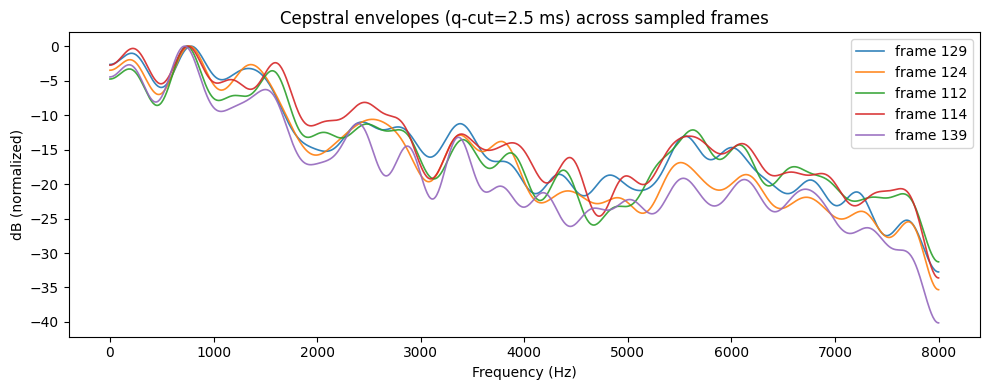

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\env_multi_clip0_vowel_mid.png


WindowsPath('c:/Users/K/Documents/usc/ee519/ee519-lecture/lecture9/EE519_L10A_Project/figures/env_multi_clip0_vowel_mid.png')

In [8]:
rng = np.random.default_rng(0)
pick = rng.choice(np.arange(K), size=min(5,K), replace=False)

fig = plt.figure(figsize=(10,4))
for i in pick:
    plt.plot(freqs, env_db_all[i], alpha=0.9, linewidth=1.2, label=f"frame {frame_ids[i]}")
plt.title(f"Cepstral envelopes (q-cut={Q_CUT_MS} ms) across sampled frames")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB (normalized)")
plt.legend()
plt.tight_layout(); plt.show()

save_fig(fig, f"env_multi_clip{CLIP_IDX}_{re.sub(r'[^a-zA-Z0-9_]+','_',segment_name)}.png")


## Wrap-up
**What you learned:** how liftering behaves across many frames, and how voiced/unvoiced differ in cepstral structure.  
**What's next:** Notebook 10A.3 tracks pitch from cepstral peaks over time and compares with autocorrelation-based pitch.


## Reflection questions
1. For your vowel segment, do you see a stable pitch ridge in the cepstrum heatmap? Why or why not?  
2. Which q-cut produced envelopes that are smooth but still show formant structure?  
3. How do fricative cepstra differ from vowel cepstra in the heatmap?  
4. If envelopes vary a lot across frames, what does that suggest about your selection?


### Answers

1. I saw a slight stable pitch ridge at 0 and 6 ms. This could be because the vowel clip was non stationary.
2. Smaller q-cuts smoothed too much to 6 ms would be good enough to see formant structure.
3. The vowel clip has a visible ridge aroudn 6 ms but the fricative did not. This could be fricatives are lower energy.
4. The frames might be too long or it could be in between the transitions of sounds.